In [1]:
import numpy as np
import scipy
import scipy.stats
import scipy.interpolate as si
from scipy.special import gammainc, gammaincinv
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns

In [2]:
gen = np.random.default_rng()

In [3]:
def sigmoid(x, mu, d, g):
    """calculates the values of a sigmoidal tuning function with midpoint mu, d=1/slope and gain g at values x"""
    mu = np.array(mu)
    d = np.array(d)
    g = np.array(g)
    shape = np.broadcast_shapes(mu.shape, d.shape, g.shape)
    x = x.reshape(x.size, *np.ones_like(shape))
    v = d*(x-mu)
    v[(v>-20) & (v<20)] = np.exp(v[(v>-20) & (v<20)])/(1+np.exp(v[(v>-20) & (v<20)]))
    v[v>=20] = 1
    v[v<=-20] = 0
    return g * v
    

In [4]:
def get_pars_dist():
    rewards = np.array([0.1, 0.3, 1.2, 2.5, 5, 10, 20])
    ps = np.array([0.066, 0.091, 0.15, 0.15, 0.31, 0.15, 0.077])
    # fitted parameters
    # mu = np.sum(np.log(rewards) * ps) / np.sum(ps)
    # v = np.sum((np.log(rewards)-mu_ml)**2 * ps) / np.sum(ps)
    # sigma = np.sqrt(v_ml)
    # ML from exact presentation numbers:
    # mu = 0.9802054796
    # sigma = 1.41029125
    # moment matching parameters
    mean = np.sum(rewards * ps) / np.sum(ps)
    var = np.sum((rewards - mean) ** 2 * ps) / np.sum(ps)
    sigma = np.log(var / mean**2 + 1)
    mu = np.log(mean) - (sigma / 2)
    sigma = np.sqrt(sigma)
    # mu = 1.297
    # sigma = 0.841
    return mu, sigma

mu_dist, sigma_dist = get_pars_dist()
def lognorm(size=None):
    #return np.exp(gen.normal(loc=mu_dist, scale=sigma_dist, size=size))
    return gen.lognormal(mean=mu_dist, sigma=sigma_dist, size=size)

def get_pars(n_neurons=20, alpha=0.77):
    q_0 = np.linspace(1/2/n_neurons,1-1/2/n_neurons, n_neurons)
    q = 1-(1-q_0) ** (1/alpha) # quantiles to converge to
    g0 = 1 / (1-q) ** alpha
    return q, g0

def update_none(mu, d, g, reward, pars=None):
    """ a dummy update rule that does not update neurons"""
    return mu, d, g

def update_quant(mu, d, g, reward, pars=None, scale=1):
    """ 
    an update rule that updates only the mus to converge to quantiles
    pars should contain the quantiles the neurons shall converge to
    """
    if pars is None:
        pars = np.linspace(1/2/len(mu), 1-(1/2/len(mu)), len(mu))
    alpha_p = 1 / (1 - pars)
    alpha_m = 1 / pars
    pos = reward > mu
    mu += pos * alpha_p * scale
    mu -= (1 - pos) * alpha_m * scale
    return mu, d, g

def update_expect(mu, d, g, reward, pars=None, scale=0.1):
    """ 
    an update rule that updates only the mus to converge to expectiles
    pars should contain the quantiles the neurons shall converge to
    """
    if pars is None:
        pars = np.linspace(1/2/len(mu), 1-(1/2/len(mu)), len(mu))
    alpha_p = pars
    alpha_m = 1-pars
    pos = reward > mu
    mu += pos * alpha_p * (reward - mu) * scale
    mu -= (1 - pos) * alpha_m * (mu - reward) * scale
    return mu, d, g


def update_d(mu, d, g, reward, pars=None, scale=0.1):
    """ 
    an update rule that updates only the density d or slope to match the efficient code prediction
    """
    if pars is None:
        pars = 0.2 * np.ones(len(mu))
    # numerically unstable version:
    # s_deriv = 4 * np.exp(d*(reward-mu)) / ((1+np.exp(d*(reward-mu))) ** 2)
    s_deriv = 4 * np.exp(d*(reward-mu) - 2 * np.logaddexp(0, d*(reward-mu)))
    d *= np.exp((s_deriv - pars) * scale)
    return mu, d, g


def update_g(mu, d, g, reward, alpha=0.77, scale=0.1):
    """
    update gain to learn the p(x)^(1-alpha)/(1-P(x))^alpha efficient code prediction
    In this version the cost that we approximate as (1-P(X)) in the analytic derivations
    is leared as a running average of the firing rate before scaling with the gain. 
    The gain is then set as d^(1-alpha) / cost^alpha
    To avoid carrying through another variable, I here compute the current cost estimate
    from the gain. In neurons keeping the cost estimate seems more realistic.
    """
    cost_old = g ** (-1/alpha)
    cost = ((1-scale) * cost_old + scale * sigmoid(np.array(reward), mu, d, 1)[0])
    g = cost ** (-alpha)
    return mu, d, g


def update_all0(mu, d, g, reward, alpha=0.77, scale=0.1, expectile=False):
    """
    full learning of an efficient code
    """
    n_neurons = len(mu)
    q, g0 = get_pars(n_neurons=n_neurons, alpha=alpha)
    if expectile:
        mu, d, g = update_expect(mu, d, g, reward, q, 2*scale)
    else:
        mu, d, g = update_quant(mu, d, g, reward, q, 2*scale)
    mu, d, g = update_d(mu, d, g, reward, None, scale)
    g = g0
    return mu, d, g


def update_all(mu, d, g, reward, alpha=0.77, scale=0.1, d_par=0.2, expectile=False):
    """
    full learning of an efficient code
    """
    n_neurons = len(mu)
    q, _ = get_pars(n_neurons=n_neurons, alpha=alpha)
    mu, d, g = update_g(mu, d, g, reward, alpha, scale)
    if expectile:
        mu, d, g = update_expect(mu, d, g, reward, q, 2*scale)
    else:
        mu, d, g = update_quant(mu, d, g, reward, q, 2*scale)
    mu, d, g = update_d(mu, d, g, reward, d_par * np.ones_like(mu), scale)
    return mu, d, g

def update_mud(mu, d, g, reward, alpha=0.77, scale=0.01, d_par=0.2, expectile=False):
    """
    learning only mu and d
    """
    n_neurons = len(mu)
    q, _ = get_pars(n_neurons=n_neurons, alpha=alpha)
    if expectile:
        mu, d, g = update_expect(mu, d, g, reward, q, 2*scale)
    else:
        mu, d, g = update_quant(mu, d, g, reward, q, 2*scale)
    mu, d, g = update_d(mu, d, g, reward, d_par * np.ones_like(mu), scale)
    return mu, d, g

In [5]:
# illustrating neurons
def plot_neurons(mu, d, g, x=np.linspace(-10,10, 1000), gca=None):
    """plots neurons with midpoints my d=1/slope and gain g"""
    if gca is None:
        gca = plt.gca()
    y = sigmoid(x, mu, d, g)
    y = y.reshape(y.shape[0], np.prod(y.shape[1:]))
    for i in range(y.shape[1]):
        gca.plot(x, y[:,i], 'k')
    gca.set_xlabel("Reward")
    gca.set_ylabel("Response[Hz]")
    sns.despine(ax=gca, trim=True)

# train neurons for many steps and show the final distribution
def train_and_show(reward_dist=lognorm, update_rule=None, n_neurons=10, mu0=None, d0=None, g0=None, pars=None, n_reward=10000, x=np.linspace(0,30, 1000)):
    if mu0 is None:
        mu0 = np.zeros(n_neurons)
    else:
        assert mu0.shape[0] == n_neurons, "mu0 has wrong length"
    if d0 is None:
        d0 = np.ones(n_neurons)
    else:
        assert d0.shape[0] == n_neurons, "d0 has wrong length"
    if g0 is None:
        g0 = np.ones(n_neurons)
    else:
        assert g0.shape[0] == n_neurons, "g0 has wrong length"
    mu = mu0
    d = d0
    g = g0
    for i in range(n_reward):
        reward = reward_dist()
        mu, d, g = update_rule(mu, d, g, reward)
    plot_neurons(mu, d, g, x=x)

    

In [6]:
# train different populations with the same training data and illustrate
def paper_plot(n_neurons=20, save_fig=None, alpha=0.77,
               slope_scale=None, use_beta=True, reward_dist=lognorm,
               expectile=False, n_reward = 100000):
    beta = 1 - alpha
    if slope_scale is None:
        slope_scale = n_neurons + 1
    # seaborn muted first colors:
    colors = \
        [(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
         (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
         (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
         (0.41568627450980394, 0.8, 0.39215686274509803),
         (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
         (0.5490196078431373, 0.3803921568627451, 0.23529411764705882)]
    colors.reverse()
    eps = np.exp(-8)
    mu_dist, sigma_dist = get_pars_dist()
    x_min = np.finfo(float).eps
    x_max = 30
    x = np.linspace(x_min, x_max, 1000)
    R = 255.19 / 39 * n_neurons
    # y_cdf = scipy.stats.norm.cdf(np.log(x), mu, sigma)
    y_pdf = scipy.stats.norm.pdf(np.log(x), mu_dist, sigma_dist) / x
    y_cdf = np.cumsum(y_pdf)
    y_pdf = y_pdf / np.sum(y_pdf)
    y_cdf /= y_cdf[-1]
    q, g0 = get_pars(n_neurons=n_neurons, alpha=alpha)
    q1, _ = get_pars(n_neurons=n_neurons, alpha=1)
    mu0 = np.ones(n_neurons)
    d0 = np.ones(n_neurons)
    g0 = np.ones(n_neurons)

    # a single neuron
    g = get_optimal_single(x, y_pdf, r_max=15, r_mean=R)
    resp1 = si.CubicSpline(x, g)
    cost1 = np.sum(resp1(x) * y_pdf) / np.sum(y_pdf)
    resp1 = si.CubicSpline(x, R * g / cost1)
    d1 = resp1.derivative()
    info1 = d1(x) ** 2 / (resp1(x) + eps)

    # quantiles with equal slope
    mu = mu0
    d = d0
    g = g0
    for i in range(n_reward):
        reward = reward_dist()
        if expectile:
            mu, d, g = update_expect(mu, d, g, reward, pars=q, scale=0.001)
        else:
            mu, d, g = update_quant(mu, d, g, reward, pars=q, scale=0.001)
    resp2 = sigmoid(x,mu,d,g).T
    cost2 = np.sum(resp2 * y_pdf) / np.sum(y_pdf)
    resp2 = R * resp2 / cost2
    info2 = np.zeros_like(x)
    for i in range(n_neurons):
        r = si.CubicSpline(x, resp2[i])
        d2 = r.derivative()
        info2 += d2(x) ** 2 / (r(x)+eps)
    print("quantiles only")
    print("mean mu: %f" % np.mean(mu))

    # quantiles and slope learned
    mu = mu0
    d = d0
    g = g0
    for i in range(n_reward):
        reward = reward_dist()
        mu, d, g = update_mud(mu, d, g, reward, alpha=alpha, scale=0.0003, expectile=expectile)
    resp3 = sigmoid(x,mu,d,g).T
    cost3 = np.nansum(resp3 * y_pdf) / np.sum(y_pdf)
    resp3 = R * resp3 / cost3
    info3 = np.zeros_like(x)
    for i in range(n_neurons):
        r = si.CubicSpline(x, resp3[i])
        d3 = r.derivative()
        info3 += d3(x) ** 2 / (r(x)+eps)
    print("quantiles + slope")
    print("mean mu: %f" % np.mean(mu))
    print("mean d: %f" % np.mean(d))

    # full learning, with gain adjustment
    mu = mu0
    d = d0
    g = g0
    for i in range(n_reward):
        reward = reward_dist()
        mu, d, g = update_all(mu, d, g, reward, alpha=alpha, scale=0.0003, expectile=expectile)
    resp4 = sigmoid(x,mu,d,g).T
    cost4 = np.sum(resp4 * y_pdf) / np.sum(y_pdf)
    resp4 = R * resp4 / cost4
    info4 = np.zeros_like(x)
    for i in range(n_neurons):
        r = si.CubicSpline(x, resp4[i])
        d4 = r.derivative()
        info4 += d4(x) ** 2 / (r(x)+eps)
    print("cost learning")
    print("mean mu: %f" % np.mean(mu))
    print("mean d: %f" % np.mean(d))
    print("mean g: %f" % (np.mean(g) * R / cost4))

    # full learning, with fixed gain scale
    mu = mu0
    d = d0
    g = g0
    for i in range(n_reward):
        reward = reward_dist()
        mu, d, g = update_all0(mu, d, g, reward, alpha=alpha, scale=0.0003, expectile=expectile)
    resp5 = sigmoid(x,mu,d,g).T
    cost5 = np.sum(resp5 * y_pdf) / np.sum(y_pdf)
    resp5 = R * resp5 / cost5
    info5 = np.zeros_like(x)
    for i in range(n_neurons):
        r = si.CubicSpline(x, resp5[i])
        d5 = r.derivative()
        info5 += d5(x) ** 2 / (r(x)+eps)
    print("a priori gain")
    print("mean mu: %f" % np.mean(mu))
    print("mean d: %f" % np.mean(d))
    print("mean g: %f" % (np.mean(g) * R / cost5))


    # optimal distribution with alpha
    resp6 = np.zeros((n_neurons, 1000))
    d = y_pdf / (1 - scipy.stats.norm.cdf(np.log(x), mu_dist, sigma_dist)) ** (1-alpha)
    cum_density = np.cumsum(d)
    cum_density /= cum_density[-1]
    thresh = np.interp(q1, cum_density, x)
    quant = np.interp(thresh, x, y_cdf)
    gain = (1
        / ((1 - scipy.stats.norm.cdf(np.log(thresh), mu_dist, sigma_dist)) ** (alpha)))
    dens = 1000*(np.interp(thresh, x, y_pdf))
    resp6 = sigmoid(x,thresh,dens,gain).T
    cost6 = np.sum(resp6 * y_pdf) / np.sum(y_pdf)
    resp6 = R * resp6 / cost6
    info6 = np.zeros_like(x)
    for i in range(n_neurons):
        r = si.CubicSpline(x, resp6[i])
        d6 = r.derivative()
        info6 += d6(x) ** 2 / (r(x)+eps)
    print("Analytic solution")
    print("mean mu: %f" % np.mean(thresh))
    print("mean d: %f" % np.mean(dens))
    print("mean g: %f" % (np.mean(gain) * R / cost6))

    y_max = 40
    y_pdf_p = 3 / 4 * y_max / np.max(y_pdf) * y_pdf
    plt.figure(figsize=(5, 14))

    a_1 = plt.axes([0.05, 0.895, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp1(x) / n_neurons, color=colors[0])
    plt.xlim(0, 20)
    a_1.spines['top'].set_visible(False)
    a_1.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_1.set_xticks(np.arange(0, 21, 5))
    a_1.set_xticklabels([])
    a_1.set_yticks([0, 10, 20, 30])

    a_2 = plt.axes([0.05, 0.79, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp2.T, color=colors[1])
    plt.xlim(0, 20)
    a_2.spines['top'].set_visible(False)
    a_2.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_2.set_xticks(np.arange(0, 21, 5))
    a_2.set_xticklabels([])
    a_2.set_yticks([0, 10, 20, 30])

    a_3 = plt.axes([0.05, 0.685, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp3.T, color=colors[2])
    plt.xlim(0, 20)
    a_3.spines['top'].set_visible(False)
    a_3.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_3.set_xticks(np.arange(0, 21, 5))
    a_3.set_xticklabels([])
    a_3.set_yticks([0, 10, 20, 30])

    a_4 = plt.axes([0.05, 0.58, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp4.T, color=colors[3])
    a_4.set_xlim(0, 20)
    a_4.spines['top'].set_visible(False)
    a_4.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_4.set_xticks(np.arange(0, 21, 5))
    a_4.set_xticklabels([])
    a_4.set_yticks([0, 10, 20, 30])

    a_5 = plt.axes([0.05, 0.475, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp5.T, color=colors[4])
    plt.xlim(0, 20)
    a_5.spines['top'].set_visible(False)
    a_5.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_5.set_xticks(np.arange(0, 21, 5))
    a_5.set_xticklabels([])
    a_5.set_yticks([0, 10, 20, 30])

    a_6 = plt.axes([0.05, 0.375, 0.9, 0.1])
    plt.plot(x, y_pdf_p, 'k', alpha=0.2)
    plt.plot(x, resp6.T, color=colors[5])
    plt.xlim(0, 20)
    a_6.spines['top'].set_visible(False)
    a_6.spines['right'].set_visible(False)
    plt.ylabel('Response [Hz]')
    plt.ylim(0, y_max)
    a_6.set_xticks(np.arange(0, 21, 5))
    a_6.set_xticklabels([])
    a_6.set_yticks([0, 10, 20, 30])

    a_info = plt.axes([0.05, 0.155, 0.9, 0.2])
    plt.plot(x, np.log2(info1), color=colors[0])
    plt.plot(x, np.log2(info2), color=colors[1])
    plt.plot(x, np.log2(info3), color=colors[2])
    plt.plot(x, np.log2(info4), color=colors[3])
    plt.plot(x, np.log2(info5), color=colors[4])
    plt.plot(x, np.log2(info6), color=colors[5])
    plt.xlim(0, 20)
    a_info.spines['top'].set_visible(False)
    a_info.spines['right'].set_visible(False)
    plt.ylabel('Fisher information [log]')
    plt.ylim(-2, 8)
    a_info.set_xticks(np.arange(0, 21, 5))

    a_bar = plt.axes([0.05, 0.025, 0.9, 0.1])
    expected_info = [np.sum(np.log2(info1) * y_pdf),
                     np.sum(np.log2(info2) * y_pdf),
                     np.sum(np.log2(info3) * y_pdf),
                     np.sum(np.log2(info4) * y_pdf),
                     np.sum(np.log2(info5) * y_pdf),
                     np.sum(np.log2(info6) * y_pdf)]
    plt.bar(np.arange(6), expected_info-expected_info[0],
            color=colors)
    plt.plot([-0.5, 5.5], [0, 0], 'k--')
    plt.ylabel('$\Delta E(\log I_f)$')#, usetex=True)
    a_bar.spines['top'].set_visible(False)
    a_bar.spines['right'].set_visible(False)
    a_bar.set_xticks(np.arange(6))
    a_bar.set_xticklabels(['one neuron', 'quantiles', 'no gain', 'learned g',
                           'fixed g', 'optimal analytic'])

    if save_fig is not None:
        plt.savefig(save_fig, format='pdf', bbox_inches='tight')


def integrate_single(x, p, lambda_r=1, f_start=1e-5, d_start=1e-5,
                     eps=1e-7):
    """ solves the differential equation for the single cell solution
    via simple iteration.
    the equation was:
        f'(x)/ f(x) = 2 p'(x)/p(x) + f(x)/F(x) + lambda_r f(x)
    """
    f = f_start
    d = d_start
    p = si.CubicSpline(x, p)
    p_d = p.derivative()
    x_last = x
    f_out = np.zeros_like(x)
    for i, x_i in enumerate(x):
        d2 = d * (p_d(x_i) / (p(x_i)+eps) + d / (f+eps) + lambda_r * d)
        d += d2 * (x-x_last)
        f += d * (x-x_last)
        x_last = x_i
        f_out[i] = f
    return f


def get_optimal_single(x, y_pdf, alpha=1.0, beta=1.0, r_max=1.0, r_mean=1.0,
                       a_thresh=10**-6):
    q = (1 - alpha / 2) / beta
    y_pdf /= np.sum(y_pdf)  # just to be sure
    u = np.cumsum(y_pdf)
    u = u / u[-1]
    g0 = r_max * u ** (1 / q)
    cost0 = np.sum(y_pdf * g0)
    if cost0 < r_mean:
        return g0
    a1 = 1
    a0 = 0
    g = r_max * (gammaincinv(q, u * gammainc(q, a1)) / a1) ** (1 / beta)
    cost1 = np.sum(y_pdf * g)
    while cost1 > r_mean:
        a1 = 2 * a1
        g = r_max * (gammaincinv(q, u * gammainc(q, a1)) / a1) ** (1 / beta)
        cost0 = cost1
        cost1 = np.sum(y_pdf * g)
    # now the best value for a is between a0 and a1
    while a1 - a0 > a_thresh:
        a = a0 + (a1-a0) / 2
        g = r_max * (gammaincinv(q, u * gammainc(q, a1)) / a1) ** (1 / beta)
        cost = np.sum(y_pdf * g)
        if cost < r_mean:
            cost1 = cost
            a1 = a
        else:
            cost0 = cost
            a0 = a
    return g

quantiles only
mean mu: 6.495195
quantiles + slope
mean mu: 6.461349
mean d: 1.920879
cost learning
mean mu: 6.465459
mean d: 1.943200
mean g: 23.354866
a priori gain
mean mu: 6.523511
mean d: 1.923623
mean g: 34.787231
Analytic solution
mean mu: 6.027395
mean d: 2.978577
mean g: 23.044283


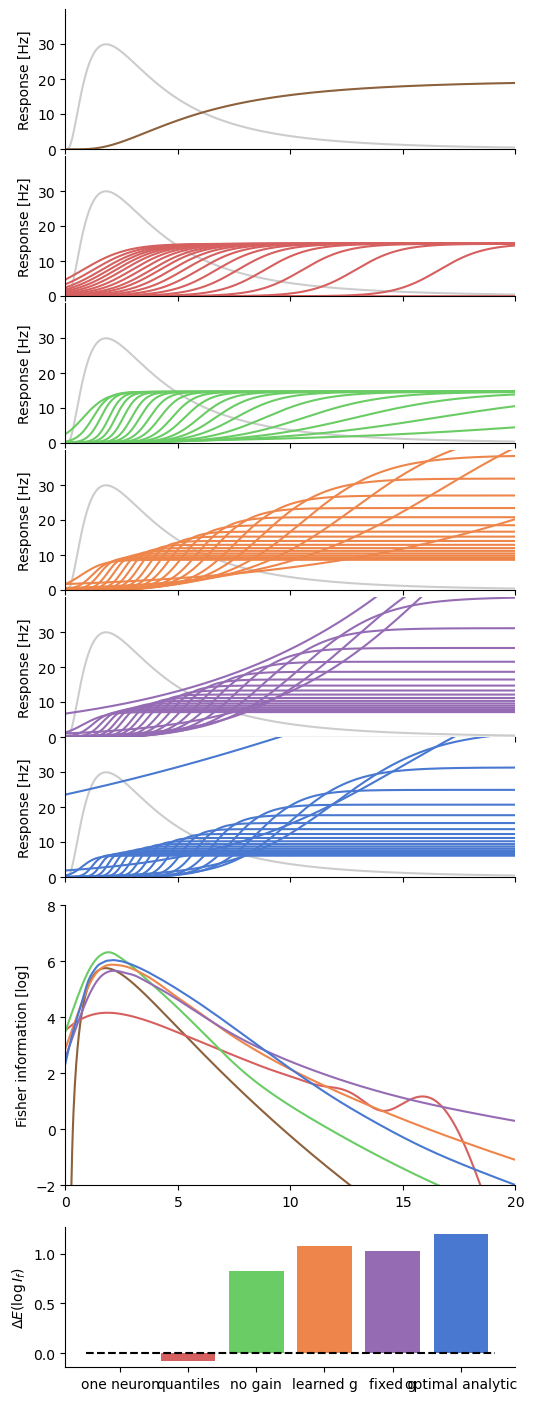

In [7]:
paper_plot(n_neurons=20, expectile=False, n_reward=100000)
plt.savefig("learning_rule.pdf")

quantiles only
mean mu: 6.513900
quantiles + slope
mean mu: 6.522441
mean d: 1.708111
cost learning
mean mu: 6.470533
mean d: 1.724396
mean g: 26.011604
a priori gain
mean mu: 6.581056
mean d: 1.721930
mean g: 38.684213
Analytic solution
mean mu: 5.399890
mean d: 3.176123
mean g: 23.491294


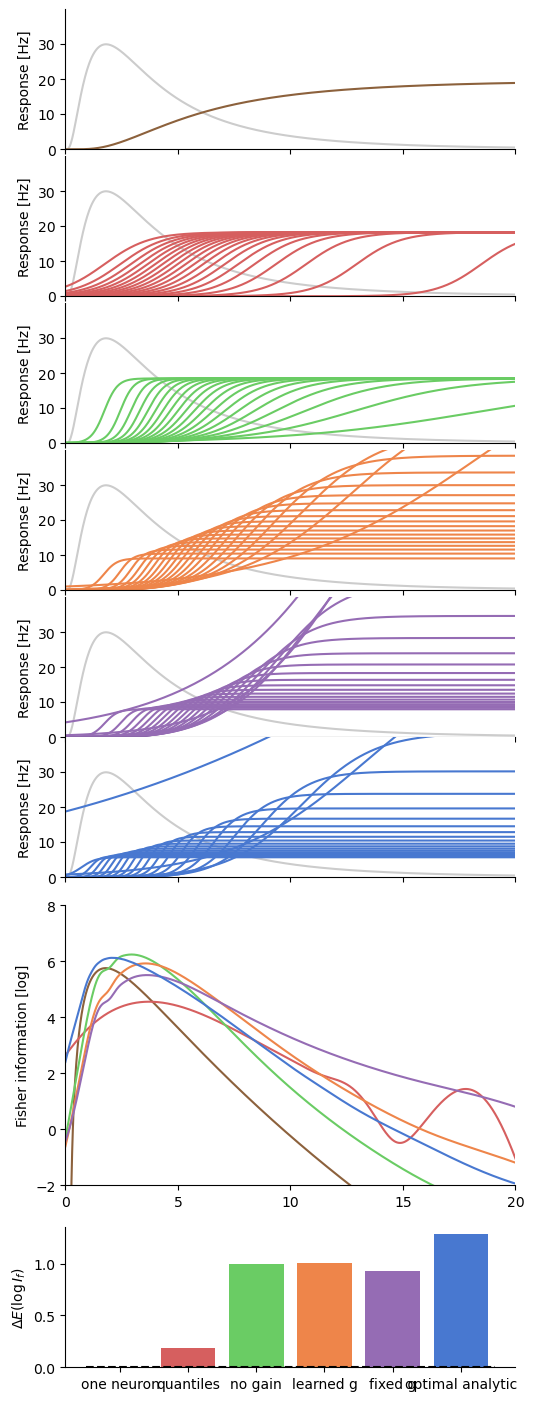

In [8]:
paper_plot(n_neurons=20, expectile=True, alpha=0.8889, n_reward=100000)
plt.savefig("learning_rule_expectile.pdf")

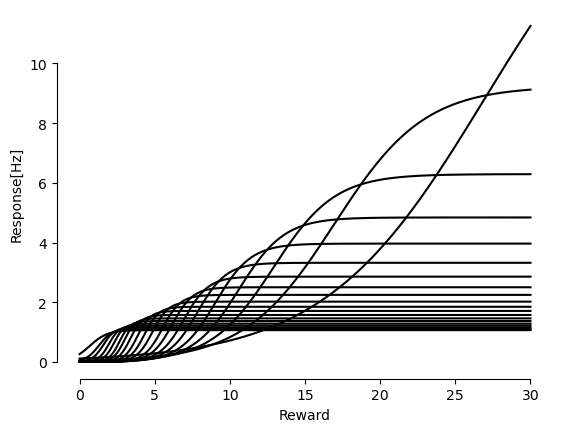

In [9]:
def update_rule(mu, d, g, reward):
    return update_all(mu, d, g, reward, alpha=0.77, scale=0.001, expectile=False)
train_and_show(update_rule=update_rule, n_neurons=20, n_reward=10000)

/var/folders/2r/y5xflhjs1zscllxn17xbl620b3rqnt/T/ipykernel_4050/689374787.py:40: RuntimeWarning: divide by zero encountered in divide
  y = 1/((1-x) ** (0.77))


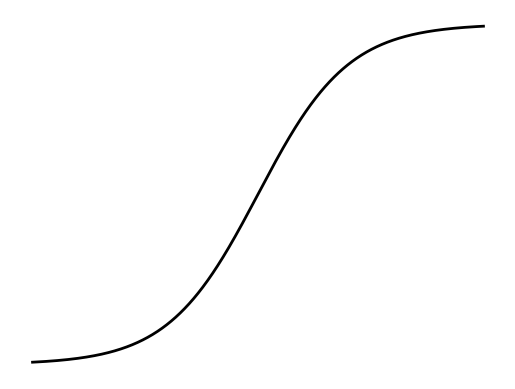

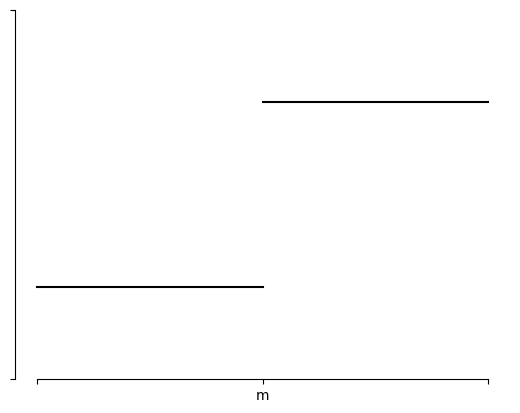

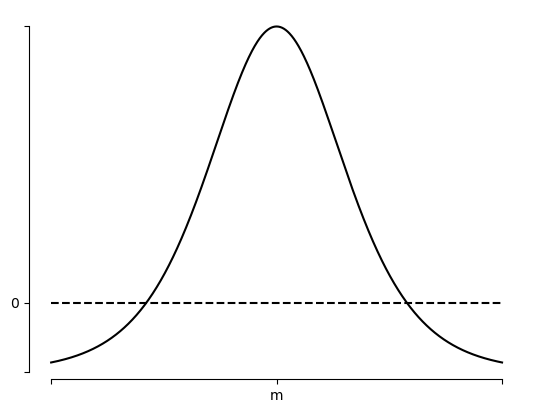

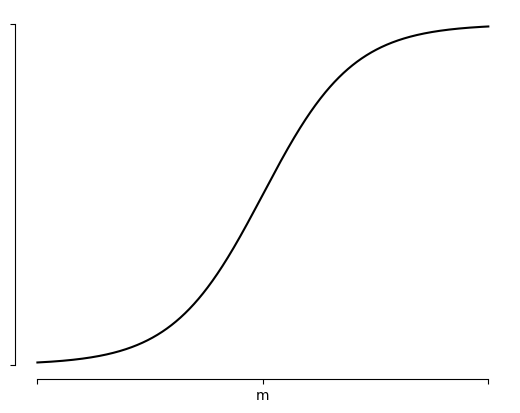

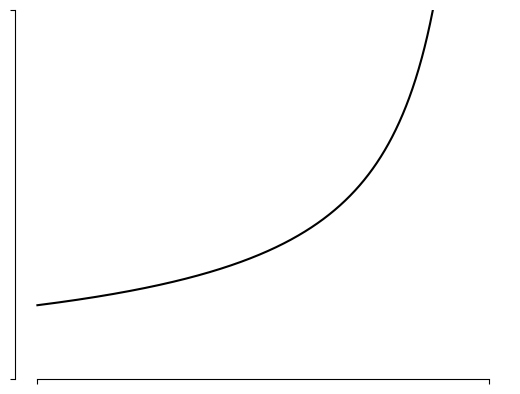

In [10]:
# Decorations
x = np.linspace(-5,5,1000)
y = sigmoid(x,0,1,1)
plt.plot(x,y, 'k', linewidth=2)
plt.axis('off')
plt.savefig("sigmoid.pdf", bbox_inches='tight')

# quantile update
plt.figure()
plt.plot([-1,0], [-1,-1], 'k')
plt.plot([0, 1], [1,1], 'k')
plt.xticks([-1,0,1], labels=["","m",""])
plt.yticks([-2, 2], labels=["",""])
sns.despine(trim=True)
plt.savefig("LRquant.pdf", bbox_inches='tight')

# slope update
plt.figure()
s_deriv = 4 * np.exp(x - 2 * np.logaddexp(0, x))
plt.plot(x, s_deriv, 'k')
plt.plot([-5, 5], [0.2, 0.2], 'k--')
plt.xticks([-5,0,5], labels=["","m",""])
plt.yticks([0,0.2, 1], labels=["","0",""])
sns.despine(trim=True)
plt.savefig("LRslope.pdf", bbox_inches='tight')

# gain update
plt.figure()
y = sigmoid(x,0,1,1)
plt.plot(x,y, 'k')
plt.xticks([-5,0,5], labels=["","m",""])
plt.yticks([0, 1], labels=["",""])
sns.despine(trim=True)
plt.savefig("LRgain.pdf", bbox_inches='tight')


# gain fixed
plt.figure()
x = np.linspace(0,1,1000)
y = 1/((1-x) ** (0.77))
plt.plot(x, y, 'k')
plt.xticks([0, 1], labels=["",""])
plt.yticks([0, 5], labels=["",""])
plt.ylim([0,5])
sns.despine(trim=True)
plt.savefig("LRFix.pdf", bbox_inches='tight')



In [16]:
mu = np.ones(10)
d = np.ones(10)
g = np.ones(10)
for i in range(10000):
    reward = gen.normal()
    update_expect(mu, d, g, reward, scale=0.01)
    update_d(mu, d, g, reward)

In [17]:
print(mu)
print(d)

[-1.18346629 -0.74191866 -0.4946238  -0.30160869 -0.13136199  0.03142806
  0.20259402  0.39964426  0.65043001  1.09268178]
[4.97518305 6.25149579 6.43889888 7.00518729 7.85468502 8.41257929
 7.13164372 6.10715527 5.35594258 4.23759762]


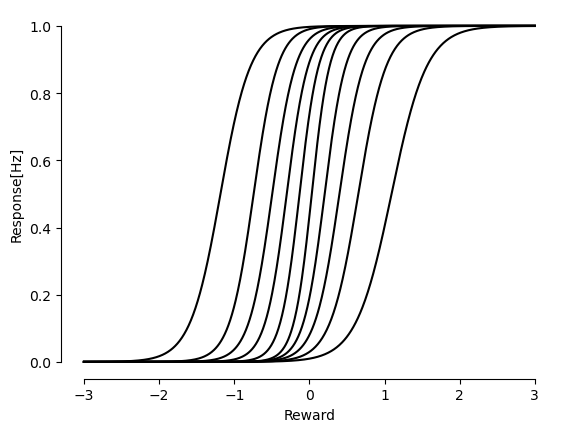

In [18]:
x = np.linspace(-3,3,1000)
plot_neurons(mu, d, g, x)

/var/folders/2r/y5xflhjs1zscllxn17xbl620b3rqnt/T/ipykernel_4050/1788353066.py:3: RuntimeWarning: divide by zero encountered in power
  pdf = (1-x) ** (alpha - 1) * alpha


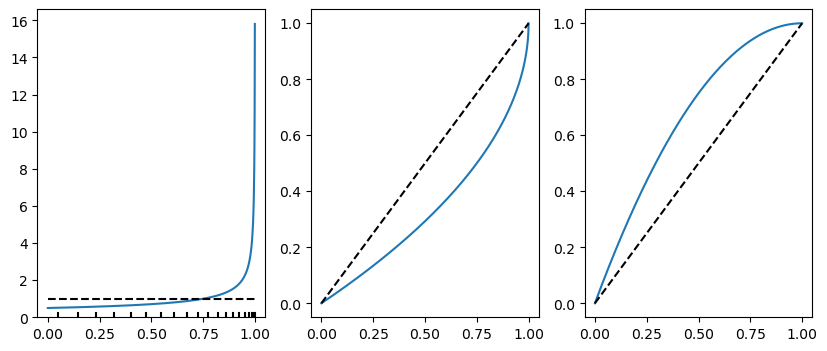

In [19]:
alpha = 0.5
x = np.linspace(0,1,1000)
pdf = (1-x) ** (alpha - 1) * alpha
cdf = 1-(1-x) ** alpha
icdf = 1-(1-x) ** (1/alpha)

n_neurons = 20
q_0 = np.linspace(1/2/n_neurons,1-1/2/n_neurons, n_neurons)
q = 1-(1-q_0) ** (1/alpha)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.plot(x,pdf)
for i_q in q:
    plt.plot([i_q,i_q], [0,0.25], 'k-')
plt.ylim(bottom=0)
plt.plot([0,1], [1,1], 'k--')
plt.subplot(1,3,2)
plt.plot(x,cdf)
plt.plot(x,x, 'k--')
plt.subplot(1,3,3)
plt.plot(x,icdf)
plt.plot(x,x, 'k--')


    

In [20]:
np.diff(q)

array([0.095, 0.09 , 0.085, 0.08 , 0.075, 0.07 , 0.065, 0.06 , 0.055,
       0.05 , 0.045, 0.04 , 0.035, 0.03 , 0.025, 0.02 , 0.015, 0.01 ,
       0.005])

In [21]:
import scipy.stats as stats

In [ ]:
samp = gen.normal(size=10000)
alph = np.linspace(0.01,0.99,99)
ep_samp = [stats.expectile(samp, a) for a in alph]
plt.plot(ep_samp, alph)

In [ ]:
gen.normal(size=10000)

In [ ]:
x = np.linspace(-5,5,1000)
t = np.linspace(-5,5,1000)
y = stats.norm.pdf(x)
diff = t.reshape(1,1000)- x.reshape(1000,1)
smaller = t.reshape(1,1000) < x.reshape(1000,1)
fplus = np.sum(-diff*smaller*y, axis=1)
fminus = np.sum(diff*(1-smaller)*y, axis=1)

In [ ]:
plt.plot(ep_samp, alph)
plt.plot(x,fplus / (fplus + fminus))


In [ ]:
get_pars(n_neurons=20, alpha=0.87)

In [ ]:
### Old now unused versions to adjust gain based on density ^alpha
def update_g0(mu, d, g, reward, g0, alpha=0.77, scale=0.1):
    """
    update gain to match the p(x)^(1-alpha)/(1-P(x))^alpha efficient code prediction
    g0 is expected to be the vector of 1/(1-P(x))^alpha
    gain is then computed as g0 * d^(1-alpha)
    This is only necessary if alpha != 1
    """
    g = g0 * (d ** (1-alpha))
    return mu, d, g


def update_g(mu, d, g, reward, alpha=0.77, scale=0.1):
    """
    update gain to learn the p(x)^(1-alpha)/(1-P(x))^alpha efficient code prediction
    In this version the cost that we approximate as (1-P(X)) in the analytic derivations
    is leared as a running average of the firing rate before scaling with the gain. 
    The gain is then set as d^(1-alpha) / cost^alpha
    To avoid carrying through another variable, I here compute the current cost estimate
    from the gain. In neurons keeping the cost estimate seems more realistic.
    """
    cost_old = (g / (d ** (1-alpha))) ** (-1/alpha)
    cost = ((1-scale) * cost_old + scale * sigmoid(np.array(reward), mu, d, 1)[0])
    g = (d ** (1-alpha)) / (cost ** alpha)
    return mu, d, g